# Unshuffling Experiments

In [10]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from fastai.vision import *
import torch
import torchvision.transforms

In [13]:
torch.cuda.set_device(1)

In [290]:
from PixelShuffle import *

In [235]:
class SoftPermutation(torch.nn.Module):
    """Permutes images"""
    def __init__(self, n, init_method, **kwargs):
        super(SoftPermutation, self).__init__()
        self.n = n
        self.permMatrix = torch.nn.Linear(n, n)
        if init_method.lower() == 'identity':
            self.permMatrix.weight.data = torch.eye(n)
        elif init_method.lower() == 'solution':
            self.permMatrix.weight.data = kwargs['data'].transpose(0,1)
        else:
            raise ValueError(f"Init method unrecognized: {init_method}")
    
    def forward(self, x):
        """Performs forward on normal NxCxHxW image tensors"""
        shape = x.shape
        x = torch.reshape(x, (shape[0], shape[1], self.n))
        x = self.permMatrix(x)
        x = torch.reshape(x, shape)
        return x
    
class StackedUnshuffler(torch.nn.Module):
    def __init__(self, n, learnedModel, init_method, **kwargs):
        super(StackedUnshuffler, self).__init__()
        self.permutation = SoftPermutation(n, init_method, **kwargs)
        self.learnedModel = learnedModel
    
    def forward(self, x):
        x = self.permutation(x)
        x = self.learnedModel(x)
        return x
    
    def freeze_model(self):
        for p in self.learnedModel.parameters():
            p.requires_grad = False

Visualizing the solution permutation matrix

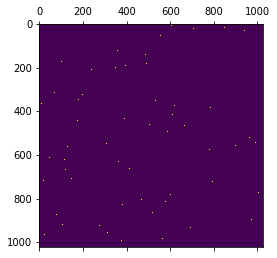

In [236]:
data, cifarShuffle = get_data_with_tfm(32, 128)
plt.matshow(cifarShuffle.createUnPermuteData())

Load learned model

In [237]:
learnedModel = models.wrn_22()
learnedModel.load_state_dict(torch.load('wrn22_pyramid_cycle'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Create unshuffled model arch

In [238]:
experiment_arch = StackedUnshuffler(32*32, learnedModel, 'solution', data=cifarShuffle.createUnPermuteData())
experiment_arch.freeze_model()

In [239]:
experiment_learner = Learner(data, experiment_arch, metrics=[accuracy])

In [240]:
preds, y, loss = experiment_learner.get_preds(with_loss=True)

In [241]:
accuracy(preds, y)

tensor(0.1000)

In [242]:
img = data.train_ds[0][0]

In [243]:
unshuffled = experiment_arch.permutation(img.data.unsqueeze(0).cuda())
solvedImg = Image(unshuffled[0].detach())

In [286]:
def solve(tensor, shuffler):
    reshaper = shuffler.createUnPermuteData()
    tensor = tensor.permute(1,2,0)
    og_shape = tensor.shape
#     tensor = torch.reshape(tensor, (-1, og_shape[-1]))
    tensor = tensor.reshape((og_shape[0]*og_shape[1], -1))[shuffler.unpermuteVector]
#     tensor = torch.matmul(tensor, reshaper.transpose(0,1))
    tensor = torch.reshape(tensor, og_shape)
    tensor = tensor.permute(2,0,1)
    return tensor

In [284]:
tmpShuffle = GlobalShuffle(4, 4)

x = torch.Tensor(list(range(48))).reshape((4,4,3)).reshape((16, 3))
y = x[tmpShuffle.permuteVector]
y = y[tmpShuffle.unpermuteVector]
y.reshape((4,4,3)), tmpShuffle.permuteVector

(tensor([[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.],
          [ 9., 10., 11.]],
 
         [[12., 13., 14.],
          [15., 16., 17.],
          [18., 19., 20.],
          [21., 22., 23.]],
 
         [[24., 25., 26.],
          [27., 28., 29.],
          [30., 31., 32.],
          [33., 34., 35.]],
 
         [[36., 37., 38.],
          [39., 40., 41.],
          [42., 43., 44.],
          [45., 46., 47.]]]),
 array([ 6, 15, 11,  8, 12,  0, 14, 13, 10,  7,  2,  5,  1,  3,  9,  4]))

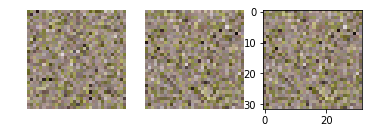

In [287]:
fig, ax = plt.subplots(ncols=3)
img.show(ax[0])
solvedImg.show(ax[1])
ax[2].imshow(solve(img.data, cifarShuffle).permute(1,2,0))
# Image(cifarShuffle.unPermuteTensor(img.data)).show(ax[2])

In [ ]:
cifarShuffle.unPermuteTensor(img.data)

In [291]:
run_tests()

True